In [29]:
import sys
sys.path.insert(0, "../../code-2023-deephyptrails/") # you might to use the absolute path here

In [30]:
from Code.Models.LightningGPT import GPT, GPTConfig
from Code.Dataset.HypothesisDataset import HypothesisDataset
from Code.Dataset.SyntheticDataset import WalkDataset
import torch
import umap
import umap.plot
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
dataset_path = "code-2023-deephyptrails/data/all-data/dataset.jsonl"  # -mixedtrail
model_path = "code-2023-deephyptrails/data/all-data/model_data-first-even-biased_final_d9b10e3c.ckpt"
feature_embedding = 1  # sometimes 25  
save_path = model_path.split("/")[-1].split("data-")[-1].split("_")[0] # None for not saving

In [80]:
dataset = HypothesisDataset(dataset_path)

In [81]:
config = GPTConfig(
    block_size=20 + 1,  # to be able to predict EOS in the end
    vocab_size=100 + 2,  # 0 for BOS and 1 for EOS, all other tokens are thus shifted by 2
    n_layer=4,
    n_head=4,
    n_embd=16,
    feature_embd_dim=feature_embedding,
    bias=False,
)
model = GPT(config)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))["state_dict"])

number of parameters: 0.01M


<All keys matched successfully>

In [82]:
model.generate(torch.IntTensor([[0]]), 25)

tensor([[ 0, 97, 40, 40, 90, 40, 36, 40, 23, 20, 94, 56, 63, 31, 75, 99, 39, 11,
         85, 77, 37,  1,  1,  1,  1,  1]])

In [83]:
model.transformer.wte.weight.shape

torch.Size([102, 16])

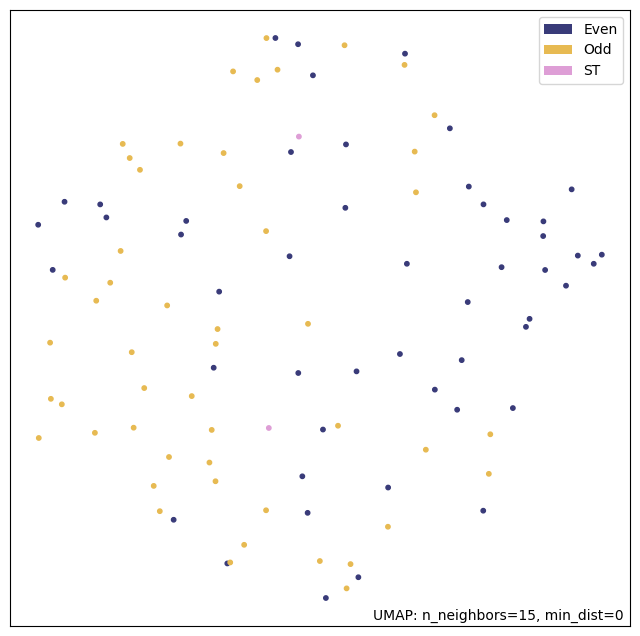

In [84]:
umap_token_red = umap.UMAP(
    n_neighbors=15,
    min_dist=0,
)
embedding = umap_token_red.fit_transform(
    model.transformer.wte.weight.detach().numpy(),
)
umap.plot.points(
    umap_token_red,
    labels=np.array(['ST'] + ['Even' if i % 2 == 0 else 'Odd' for i in range(100)] + ['ST']),
    theme="red",
)
if save_path:
    plt.savefig(f"code-2023-deephyptrails/data/potential-paper-figures/model-{save_path}-umap.pdf")

In [85]:
for hypothesis, hypothesis_walks in dataset.hypothesis_walks.items():
    print(hypothesis, len(hypothesis_walks))

hyp-even 100000
hyp-odd 100000
hyp-first-even 100000
hyp-first-odd 100000
hyp-three-even-one-odd 100000
hyp-three-odd-one-even 100000
hyp-two-even-two-odd 100000
hyp-rand 100000
hyp-tele 100000
hyp-even-biased 100000
hyp-odd-biased 100000
hyp-first-even-biased 100000
hyp-first-odd-biased 100000
hyp-rand-biased 100000
hyp-tele-biased 100000


In [86]:
walkies = torch.IntTensor(dataset.hypothesis_walks["hyp-first-even"][:100])
input_walkies = torch.cat(
    [torch.IntTensor([0]).repeat(walkies.shape[0]).unsqueeze(1), (walkies + 2)],
    dim=1,
)
target_walkies = torch.cat(
    [(walkies + 2), torch.IntTensor([1]).repeat(walkies.shape[0]).unsqueeze(1)],
    dim=1,
)

results = model(input_walkies, return_last_hidden_state=True)

<Axes: >

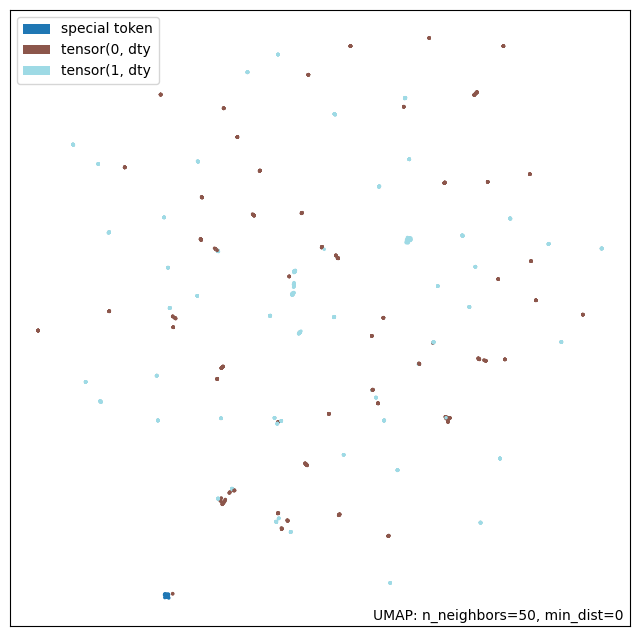

In [87]:
how_many = 3000

umap_hidden_red = umap.UMAP(
    n_neighbors=50,
    min_dist=0,
    n_jobs=8
)
embedding = umap_hidden_red.fit_transform(
    results["last_hidden_state"][:how_many, ...].view(-1, 16).detach().numpy().astype(np.half),
)
umap.plot.points(
    umap_hidden_red,
    labels=np.array([i % 2 if i > 1 else "special token" for i in input_walkies[:how_many, ...].view(-1)]),
    theme="blue",
)

In [88]:
def plot_walks(name: str, by: str, walkies: torch.IntTensor):
    input_walkies = torch.cat(
        [torch.LongTensor([0]).repeat(walkies.shape[0]).unsqueeze(1), (walkies + 2)],
        dim=1,
    )
    target_walkies = torch.cat(
        [(walkies + 2), torch.LongTensor([1]).repeat(walkies.shape[0]).unsqueeze(1)],
        dim=1,
    )

    results = model(input_walkies, target_walkies, return_last_hidden_state=True)
    likeliest_tokens_ranked = results["logits"].argsort(2, descending=True)
    ranks = (target_walkies.unsqueeze(-1) == likeliest_tokens_ranked).nonzero()

    ranks_df = pd.DataFrame(ranks, columns=["sample", "step", "rank"])
    ranks_df["target_token"] = target_walkies.flatten()
    ranks_df["predicted_token"] = results["logits"].argmax(2).flatten()

    if by == "decoding_step":
        ranks_df.groupby("step").mean()["rank"].plot(
            xticks=list(range(21)),
            label=' '.join(name.split("-")[1:]).title() + f" ({results['loss'].item():.2f})",
            xlabel="decoding time step",
            ylabel="avg. rank",
        )
    elif by == "rank":
        ranks_df.groupby("rank").count()["step"].plot(
            label=name,
            xlabel="rank (lower is better)",
            ylabel="count (more at low ranks is better)",
        )
    elif by == "target_token":
        ranks_df.groupby("target_token").mean()["rank"].plot(
            label=name,
            xlabel="target token",
            ylabel="rank (lower is better)",
        )
    elif by == "predicted_token":
        ranks_df.groupby("predicted_token").mean()["rank"].plot(
            label=name,
            xlabel="predicted token",
            ylabel="rank (lower is better)",
        )
    else:
        raise NotImplementedError

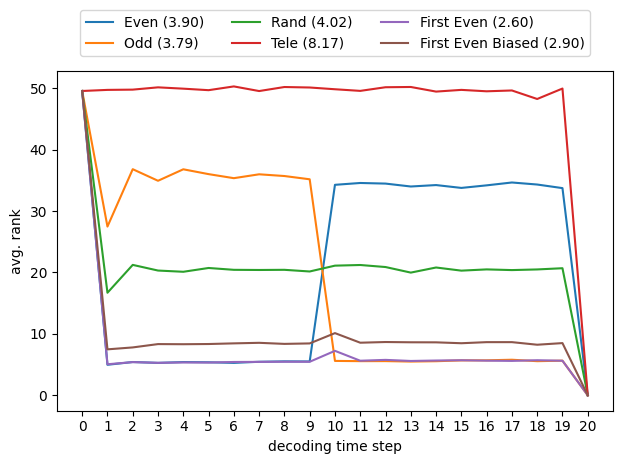

In [89]:
plot_walks_by="decoding_step"  # rank, decoding_step, target_token, predicted_token
# plt.style.use(['science', 'nature'])
# plt.figure(figsize=(6.4, 4.8))
# all_hypotheses = ["hyp-even", "hyp-odd", "hyp-first-even", "hyp-first-odd", "hyp-rand", "hyp-tele"]
# hypotheses = ["hyp-even", "hyp-odd", "hyp-rand", "hyp-tele", "hyp-first-even", "hyp-two-even-two-odd",]
hypotheses = ["hyp-even", "hyp-odd", "hyp-rand", "hyp-tele", "hyp-first-even", "hyp-first-even-biased"]
for hypothesis in hypotheses:
    walkies = torch.IntTensor(dataset.hypothesis_walks[hypothesis][:5000])
    # biased_walkies = torch.IntTensor(dataset.hypothesis_walks[f"{hypothesis}-biased"][:5000])
    plot_walks(
        name=hypothesis,
        by=plot_walks_by,
        walkies=walkies,
    )
plt.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.2))
plt.tight_layout()
plt.xticks(minor=False)
if save_path:
    plt.savefig(f"code-2023-deephyptrails/data/potential-paper-figures/model-{save_path}-{plot_walks_by}.pdf")